In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [2]:
os.chdir('/opt/ml/P-Stage/1-STAGE/')

In [3]:
from config import get_args
from prepare import get_dataloader, get_transforms

args = get_args()
args.device = "cuda:0" if torch.cuda.is_available() else "cpu"

args.test = True
args.train_key = "mask"

_, dataloader = get_dataloader(args)
images, labels = next(iter(dataloader))
images, labels = images.cuda(), labels.cuda()

In [4]:
models.resnet101()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
images.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [6]:
from predict import load_models
models = load_models(args)

In [5]:
sample_path = '/opt/ml/input/data/eval/images/0001b62fb1057a1182db2c839de232dbef0d1e90.jpg'
pil_img = PIL.Image.open(sample_path)

torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(args.device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [6]:
torch_img.shape, normed_torch_img.shape

(torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [7]:
cams = [[
    GradCAM.from_config(model_type="resnet", arch=models[0], layer_name='layer4'),
    GradCAMpp.from_config(model_type="resnet", arch=models[0], layer_name='layer4')
]]

In [8]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

NameError: name 'normed_torch_img' is not defined

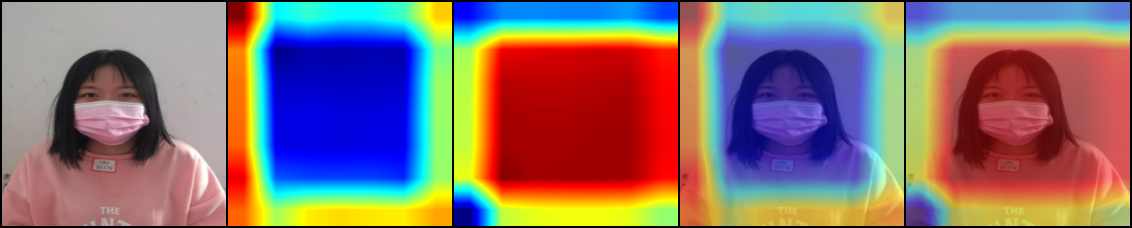

In [9]:
transforms.ToPILImage()(grid_image)

In [11]:
images[0]

tensor([[[0.6431, 0.6431, 0.6471,  ..., 0.6980, 0.6980, 0.6980],
         [0.6431, 0.6431, 0.6471,  ..., 0.6980, 0.6980, 0.6980],
         [0.6431, 0.6431, 0.6471,  ..., 0.6980, 0.6980, 0.6980],
         ...,
         [0.6549, 0.6667, 0.6706,  ..., 0.7725, 0.7765, 0.7843],
         [0.6510, 0.6627, 0.6667,  ..., 0.7725, 0.7804, 0.7882],
         [0.6510, 0.6588, 0.6667,  ..., 0.7765, 0.7882, 0.8000]],

        [[0.6392, 0.6392, 0.6431,  ..., 0.6902, 0.6902, 0.6902],
         [0.6392, 0.6392, 0.6431,  ..., 0.6902, 0.6902, 0.6902],
         [0.6392, 0.6392, 0.6431,  ..., 0.6902, 0.6902, 0.6902],
         ...,
         [0.4196, 0.4314, 0.4353,  ..., 0.4980, 0.5020, 0.5137],
         [0.4157, 0.4275, 0.4314,  ..., 0.4980, 0.5059, 0.5176],
         [0.4157, 0.4235, 0.4314,  ..., 0.5020, 0.5137, 0.5294]],

        [[0.6314, 0.6314, 0.6353,  ..., 0.6941, 0.6941, 0.6941],
         [0.6314, 0.6314, 0.6353,  ..., 0.6941, 0.6941, 0.6941],
         [0.6314, 0.6314, 0.6353,  ..., 0.6941, 0.6941, 0.

In [9]:
# tensor images, models

MEAN = torch.tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1).cuda()
STD = torch.tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1).cuda()

In [10]:
images, labels = next(iter(dataloader))
images, labels = images.cuda(), labels.cuda()

In [11]:
empty = torch.empty_like(images).cpu()

In [12]:
images = (images * STD) + MEAN

for _, gradcam_pp in cams:
    for idx, image in enumerate(images):
        mask_pp, _ = gradcam_pp(image.unsqueeze(0))
#         torch_img = (image * STD) + MEAN
        heatmap_pp, result_pp = visualize_cam(mask_pp, image)
        
        empty[idx] = result_pp

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [13]:
empty.shape

torch.Size([64, 3, 224, 224])

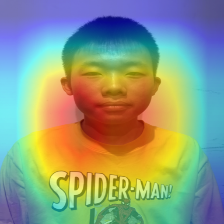

In [36]:
transforms.ToPILImage()(empty[21])

In [20]:
empty[0].min(), empty[0].max()

(tensor(-0.7557), tensor(1.))

In [21]:
(images[0] * STD) + MEAN

tensor([[[0.6235, 0.6235, 0.6196,  ..., 0.3843, 0.3843, 0.3804],
         [0.6235, 0.6235, 0.6196,  ..., 0.3882, 0.3843, 0.3843],
         [0.6235, 0.6235, 0.6196,  ..., 0.3922, 0.3882, 0.3882],
         ...,
         [0.1725, 0.1686, 0.1608,  ..., 0.1216, 0.1294, 0.1333],
         [0.1608, 0.1569, 0.1529,  ..., 0.1176, 0.1255, 0.1294],
         [0.1333, 0.1294, 0.1216,  ..., 0.1176, 0.1216, 0.1255]],

        [[0.6353, 0.6353, 0.6314,  ..., 0.3843, 0.3843, 0.3804],
         [0.6353, 0.6353, 0.6314,  ..., 0.3882, 0.3843, 0.3843],
         [0.6353, 0.6353, 0.6314,  ..., 0.3922, 0.3882, 0.3882],
         ...,
         [0.3451, 0.3412, 0.3333,  ..., 0.1608, 0.1647, 0.1686],
         [0.3333, 0.3294, 0.3255,  ..., 0.1569, 0.1608, 0.1647],
         [0.3059, 0.3020, 0.2941,  ..., 0.1569, 0.1569, 0.1608]],

        [[0.6078, 0.6078, 0.6039,  ..., 0.3529, 0.3529, 0.3490],
         [0.6078, 0.6078, 0.6039,  ..., 0.3569, 0.3529, 0.3529],
         [0.6078, 0.6078, 0.6039,  ..., 0.3608, 0.3569, 0.